In [7]:
import numpy as np
import mne
from mne.preprocessing import ICA
from matplotlib import pyplot as plt
import os

In [14]:
train_autokl = np.load('../cache/thingseeg2_preproc/extracted_embeddings/train_autokl.npy', mmap_mode='r')
train_cliptext = np.load('../cache/thingseeg2_preproc/extracted_embeddings/train_cliptext.npy', mmap_mode='r')
train_clipvision = np.load('../cache/thingseeg2_preproc/extracted_embeddings/train_clipvision.npy', mmap_mode='r')
test_autokl = np.load('../cache/thingseeg2_preproc/extracted_embeddings/test_autokl.npy', mmap_mode='r')
test_cliptext = np.load('../cache/thingseeg2_preproc/extracted_embeddings/test_cliptext.npy', mmap_mode='r')
test_clipvision = np.load('../cache/thingseeg2_preproc/extracted_embeddings/test_clipvision.npy', mmap_mode='r')
print(train_autokl.shape, train_cliptext.shape, train_clipvision.shape)
print(test_autokl.shape, test_cliptext.shape, test_clipvision.shape)
# train_autokl = train_autokl[..., np.newaxis]
# test_autokl = test_autokl[..., np.newaxis]
train_autokl = train_autokl.T
test_autokl = test_autokl.T
train_cliptext = train_cliptext[:,1].T
test_cliptext = test_cliptext[:,1].T
train_clipvision = train_clipvision[:,0].T
test_clipvision = test_clipvision[:,0].T
# train_cliptext = train_cliptext.reshape(train_cliptext.shape[0], -1).T
# train_cliptext = train_cliptext[..., np.newaxis]
# test_cliptext = test_cliptext.reshape(test_cliptext.shape[0], -1).T
# test_cliptext = test_cliptext[..., np.newaxis]
# train_clipvision = train_clipvision.reshape(train_clipvision.shape[0], -1).T
# train_clipvision = train_clipvision[..., np.newaxis]
# test_clipvision = test_clipvision.reshape(test_clipvision.shape[0], -1).T
# test_clipvision = test_clipvision[..., np.newaxis]
print(train_autokl.shape, train_cliptext.shape, train_clipvision.shape)
print(test_autokl.shape, test_cliptext.shape, test_clipvision.shape)

(16540, 91168) (16540, 77, 768) (16540, 257, 768)
(200, 91168) (200, 77, 768) (200, 257, 768)
(91168, 16540) (768, 16540) (768, 16540)
(91168, 200) (768, 200) (768, 200)


In [15]:
autokl_info = mne.create_info(train_autokl.shape[0], 1, 'eeg')
cliptext_info = mne.create_info(train_cliptext.shape[0], 1, 'eeg')
clipvision_info = mne.create_info(train_clipvision.shape[0], 1, 'eeg')
mne_train_autokl = mne.io.RawArray(train_autokl, autokl_info)
mne_train_cliptext = mne.io.RawArray(train_cliptext, cliptext_info)
mne_train_clipvision = mne.io.RawArray(train_clipvision, clipvision_info)
mne_test_autokl = mne.io.RawArray(test_autokl, autokl_info)
mne_test_cliptext = mne.io.RawArray(test_cliptext, cliptext_info)
mne_test_clipvision = mne.io.RawArray(test_clipvision, clipvision_info)

Creating RawArray with float64 data, n_channels=91168, n_times=16540
    Range : 0 ... 16539 =      0.000 ... 16539.000 secs
Ready.
Creating RawArray with float64 data, n_channels=768, n_times=16540
    Range : 0 ... 16539 =      0.000 ... 16539.000 secs
Ready.
Creating RawArray with float64 data, n_channels=768, n_times=16540
    Range : 0 ... 16539 =      0.000 ... 16539.000 secs
Ready.
Creating RawArray with float64 data, n_channels=91168, n_times=200
    Range : 0 ... 199 =      0.000 ...   199.000 secs
Ready.
Creating RawArray with float64 data, n_channels=768, n_times=200
    Range : 0 ... 199 =      0.000 ...   199.000 secs
Ready.
Creating RawArray with float64 data, n_channels=768, n_times=200
    Range : 0 ... 199 =      0.000 ...   199.000 secs
Ready.


In [4]:
# create ica instance with defined parameters
ica = ICA(0.999999, # number of components to extract. Here we use .95 meaning...
          # ...'as many as necessary to account for 95% of data variance...
          # in a preliminary PCA'
          max_iter= 1000, # max iterations allowed for the algorithm
          random_state=1, # this is just so you can replicate my results
          method = 'infomax', # algorithm used
          fit_params=dict(extended = True) # algorithm-specific parameters ...
         )                               #...(in this case 'use extended infomax')

In [5]:
# fit ica with the parameters above to the data
ica.fit(mne_train_clipvision, # data
        picks = 'eeg', # channels to use
        # reject = dict(eeg = 300e-6) # threshold to ignore parts of the signal
       )

Fitting ICA to data using 768 channels (please be patient, this may take a while)


/tmp/ipykernel_3142077/3099865138.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(mne_train_clipvision, # data


Selecting by explained variance: 755 components
Computing Extended Infomax ICA
Fitting ICA took 905.6s.


Method,infomax
Fit parameters,extended=Truemax_iter=1000
Fit,81 iterations on raw data (16540 samples)
ICA components,755
Available PCA components,768
Channel types,eeg
ICA components marked for exclusion,—


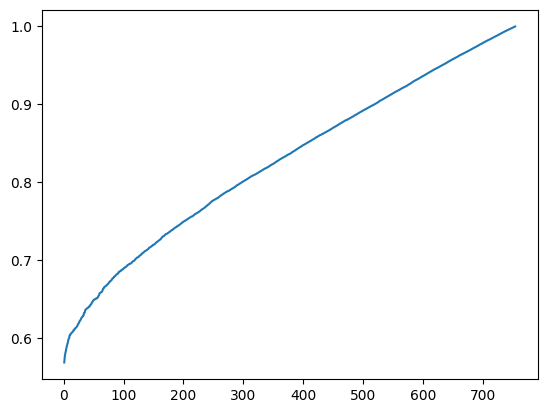

In [6]:
variance_ratios = []
variance_explained = []
for i in range(1, 755):
    variance_ratios.append(ica.get_explained_variance_ratio(mne_test_clipvision, components=list(range(i)))['eeg'])
    # variance_explained.append(ica.get_explained_variance_ratio(mne_test_clipvision, components=i-1)['eeg'])
# plt.plot(range(1, 755), variance_ratios, marker='o');
plt.plot(range(1, 755), variance_ratios);
# plt.bar(range(1, 755), variance_explained, alpha=0.5);
plt.show();

In [8]:
mne_cls_5 = mne_test_clipvision.copy()
mne_cls_10 = mne_test_clipvision.copy()
mne_cls_25 = mne_test_clipvision.copy()
mne_cls_50 = mne_test_clipvision.copy()
mne_cls_100 = mne_test_clipvision.copy()
ica.apply(mne_cls_5, include=list(range(5)))
ica.apply(mne_cls_10, include=list(range(10)))
ica.apply(mne_cls_25, include=list(range(25)))
ica.apply(mne_cls_50, include=list(range(50)))
ica.apply(mne_cls_100, include=list(range(100)))

Applying ICA to Raw instance
    Transforming to ICA space (755 components)
    Zeroing out 750 ICA components
    Projecting back using 768 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (755 components)
    Zeroing out 745 ICA components
    Projecting back using 768 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (755 components)
    Zeroing out 730 ICA components
    Projecting back using 768 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (755 components)
    Zeroing out 705 ICA components
    Projecting back using 768 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (755 components)
    Zeroing out 655 ICA components
    Projecting back using 768 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,768 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1.00 Hz
Highpass,0.00 Hz
Lowpass,0.50 Hz


In [39]:
dir = '../cache/thingseeg2_synthetic/ica_embeddings'
if not os.path.exists(dir):
   os.makedirs(dir)
np.save(f'{dir}/test_clipvisioncls', np.repeat(test_clipvision[np.newaxis, :], 257, axis=0).transpose((2,0,1)))
np.save(f'{dir}/test_clipvisioncls_ica5', np.repeat(mne_cls_5.get_data()[np.newaxis, :], 257, axis=0).transpose((2,0,1)))
np.save(f'{dir}/test_clipvisioncls_ica10', np.repeat(mne_cls_10.get_data()[np.newaxis, :], 257, axis=0).transpose((2,0,1)))
np.save(f'{dir}/test_clipvisioncls_ica25', np.repeat(mne_cls_25.get_data()[np.newaxis, :], 257, axis=0).transpose((2,0,1)))
np.save(f'{dir}/test_clipvisioncls_ica50', np.repeat(mne_cls_50.get_data()[np.newaxis, :], 257, axis=0).transpose((2,0,1)))
np.save(f'{dir}/test_clipvisioncls_ica100', np.repeat(mne_cls_100.get_data()[np.newaxis, :], 257, axis=0).transpose((2,0,1)))

In [38]:
np.repeat(test_clipvision[np.newaxis, :], 257, axis=0).transpose((2,0,1)).shape

(200, 257, 768)

In [12]:
# create ica instance with defined parameters
ica = ICA(0.999999, # number of components to extract. Here we use .95 meaning...
          # ...'as many as necessary to account for 95% of data variance...
          # in a preliminary PCA'
          max_iter= 1000, # max iterations allowed for the algorithm
          random_state=1, # this is just so you can replicate my results
          method = 'infomax', # algorithm used
          fit_params=dict(extended = True) # algorithm-specific parameters ...
         )   

In [16]:
# fit ica with the parameters above to the data
ica.fit(mne_train_cliptext, # data
        picks = 'eeg', # channels to use
        # reject = dict(eeg = 300e-6) # threshold to ignore parts of the signal
       )

Fitting ICA to data using 768 channels (please be patient, this may take a while)


/tmp/ipykernel_3142077/3116720221.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(mne_train_cliptext, # data


Selecting by explained variance: 728 components
Computing Extended Infomax ICA
Fitting ICA took 456.9s.


Method,infomax
Fit parameters,extended=Truemax_iter=1000
Fit,86 iterations on raw data (16540 samples)
ICA components,728
Available PCA components,768
Channel types,eeg
ICA components marked for exclusion,—


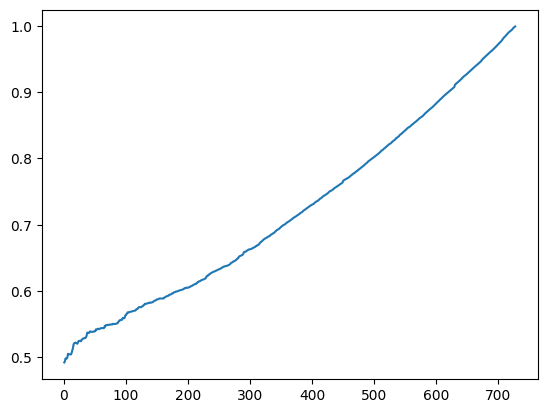

In [17]:
variance_ratios = []
variance_explained = []
for i in range(1, 728):
    variance_ratios.append(ica.get_explained_variance_ratio(mne_test_cliptext, components=list(range(i)))['eeg'])
    # variance_explained.append(ica.get_explained_variance_ratio(mne_test_clipvision, components=i-1)['eeg'])
# plt.plot(range(1, 755), variance_ratios, marker='o');
plt.plot(range(1, 728), variance_ratios);
# plt.bar(range(1, 755), variance_explained, alpha=0.5);
plt.show();

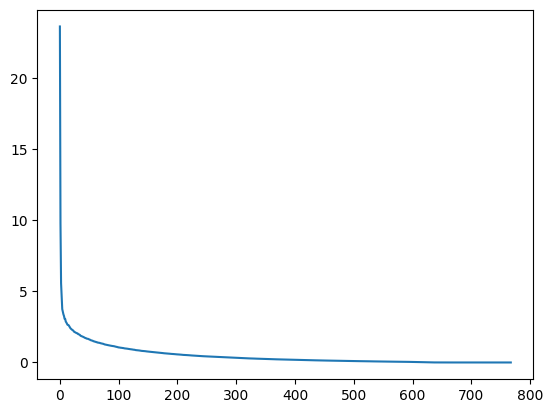

In [20]:
mne_eos_5 = mne_test_cliptext.copy()
mne_eos_10 = mne_test_cliptext.copy()
mne_eos_25 = mne_test_cliptext.copy()
mne_eos_50 = mne_test_cliptext.copy()
mne_eos_100 = mne_test_cliptext.copy()
ica.apply(mne_eos_5, include=list(range(5)))
ica.apply(mne_eos_10, include=list(range(10)))
ica.apply(mne_eos_25, include=list(range(25)))
ica.apply(mne_eos_50, include=list(range(50)))
ica.apply(mne_eos_100, include=list(range(100)))

Applying ICA to Raw instance
    Transforming to ICA space (728 components)
    Zeroing out 723 ICA components
    Projecting back using 768 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (728 components)
    Zeroing out 718 ICA components
    Projecting back using 768 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (728 components)
    Zeroing out 703 ICA components
    Projecting back using 768 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (728 components)
    Zeroing out 678 ICA components
    Projecting back using 768 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (728 components)
    Zeroing out 628 ICA components
    Projecting back using 768 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,768 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1.00 Hz
Highpass,0.00 Hz
Lowpass,0.50 Hz


In [37]:
dir = '../cache/thingseeg2_synthetic/ica_embeddings'
if not os.path.exists(dir):
   os.makedirs(dir)
np.save(f'{dir}/test_cliptexteos', np.repeat(test_cliptext[np.newaxis, :], 77, axis=0).transpose((2,0,1)))
np.save(f'{dir}/test_cliptexteos_ica5', np.repeat(mne_eos_5.get_data()[np.newaxis, :], 77, axis=0).transpose((2,0,1)))
np.save(f'{dir}/test_cliptexteos_ica10', np.repeat(mne_eos_10.get_data()[np.newaxis, :], 77, axis=0).transpose((2,0,1)))
np.save(f'{dir}/test_cliptexteos_ica25', np.repeat(mne_eos_25.get_data()[np.newaxis, :], 77, axis=0).transpose((2,0,1)))
np.save(f'{dir}/test_cliptexteos_ica50', np.repeat(mne_eos_50.get_data()[np.newaxis, :], 77, axis=0).transpose((2,0,1)))
np.save(f'{dir}/test_cliptexteos_ica100', np.repeat(mne_eos_100.get_data()[np.newaxis, :], 77, axis=0).transpose((2,0,1)))

In [27]:
np.repeat(mne_eos_5.get_data()[np.newaxis, :], 77, axis=0).transpose((2,0,1)).shape

(200, 77, 768)

In [35]:
np.repeat(test_cliptext[np.newaxis, :], 77, axis=0).transpose((2,0,1)).shape

(200, 77, 768)